## Create Flood Inundation Map based on the HAND Method

**Authors**: Anthony Castronova (acastronova@cuahsi.org), Irene Garousi-Nejad (igarousi@cuahsi.org)  <br>
**Last updated**: Mar 11, 2024

This notebook shows how to access the National Water Model version 3 retrospective simulated data, in particular, the streamflow. Data is stored on AWS and can be accessed through the following link. This notebook has been tested on the CIROH 2i2c Cloud infrastructure. The printed computation times correspond to a **Medium server**, with 11GB of RAM and 4 CPUs. 

Funding Resources:

<img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CIROHLogo_200x200.png" width="100" height="20">     <img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CUAHSI-4-color-logo_with_URL.png" width="300" height="300">

In [1]:
import pandas as pd
from scipy import interpolate
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import xarray 
import fsspec
import numpy as np
from osgeo import gdal
import numpy.ma as ma

import fim_utils_v2

In [2]:
import os
import s3fs
import boto3
import fsspec
import pandas as pd
import numpy as np
import xarray as xr
import zarr
import glob
import rasterio
import pyproj
import geopandas
import matplotlib.pyplot as plt

In [5]:
import dask
from dask.distributed import Client
from dask.distributed import progress
try:
    print(client.dashboard_link)
except:    
    client = Client(n_workers=24, threads_per_worker=1, memory_limit='2GB') 
    print(client.dashboard_link)

/user/igarousi/proxy/8787/status


In [97]:
import importlib
importlib.reload(fim_utils)

<module 'fim_utils' from '/home/jovyan/NWM_inputs_outputs/NWM/v3-STREAMFLOW/fim_utils.py'>

## 1. Collect NWM Flood Inundation Map (FIM) Data 

#### Specify the region of interest (HUC8)

In [7]:
# hydroTable_0.csv
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
 s3 cp s3://scratch/hand_fim/16010102/branches/0/hydroTable_0.csv .

# rem_zeroed_masked_0.tif
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
 s3 cp s3://scratch/hand_fim/16010102/branches/0/rem_zeroed_masked_0.tif .

# gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
s3 cp s3://scratch/hand_fim/16010102/branches/0/gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg .

# gw_catchments_reaches_filtered_addedAttributes_0.tif
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
s3 cp s3://scratch/hand_fim/16010102/branches/0/gw_catchments_reaches_filtered_addedAttributes_0.tif .

download: s3://scratch/hand_fim/16010102/branches/0/hydroTable_0.csv to ./hydroTable_0.csv
download: s3://scratch/hand_fim/16010102/branches/0/rem_zeroed_masked_0.tif to ./rem_zeroed_masked_0.tif
download: s3://scratch/hand_fim/16010102/branches/0/gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg to ./gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg
download: s3://scratch/hand_fim/16010102/branches/0/gw_catchments_reaches_filtered_addedAttributes_0.tif to ./gw_catchments_reaches_filtered_addedAttributes_0.tif


## 2. Retrieve NWM streamflow data

In [8]:
%%time
ds = conus_bucket_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/chrtout.zarr'

ds = xarray.open_zarr(
        fsspec.get_mapper(
            conus_bucket_url,
            anon=True
        ),
        consolidated=True
)

CPU times: user 8.3 s, sys: 1.59 s, total: 9.89 s
Wall time: 48.8 s


#### Specify the location of interest and find associated NWM reach ID

In [9]:
%%time
geo_lon = -111.0538022
geo_lat = 42.21104338

ds_sel = ds.isel(time=0).compute()
nwm_reach_id = fim_utils.get_nwm_id(geo_lat, geo_lon, ds_sel)
print(nwm_reach_id)

7898927
CPU times: user 7.65 s, sys: 2.35 s, total: 10 s
Wall time: 56.2 s


#### Specify the period of interest and subset data for the location and period of interest

In [10]:
%%time
nwm_reach_id=nwm_reach_id
start_date='2013-10-01'
end_date='2014-10-01'
output_path= f'./subset_nwm_q_for_{nwm_reach_id}_wy2008'

# revise: ds should also be an input to the following function.
df = fim_utils.get_nwm_q(nwm_reach_id, start_date, end_date, output_path)

Loading the metadata
Subset started ...
Subset finished!
Saving results in a csv file ...
Subset is completed.
CPU times: user 8.13 s, sys: 1.64 s, total: 9.77 s
Wall time: 52.8 s


In [11]:
df.loc[df['streamflow_m3 s-1'] == df['streamflow_m3 s-1'].max()]

,elevation,feature_id,gage_id,latitude,longitude,order,streamflow_m3 s-1
time,,,,,,,
2014-06-03 23:00:00,1847.48999,7898927,b' 10039500',42.208435,-111.059891,6,96.659998


## 3. Estimate Flood Depth for each HydroID within the Catchment

In [12]:
nwm_reach_id = nwm_reach_id
discharge_cms = df['streamflow_m3 s-1'].max()

print("\nTest HydroID reach stages:\n")
res = fim_utils.get_stage_for_all_hydroids_in_reach(nwm_reach_id, discharge_cms)
print(f'{"NHD FeatureID":^15}  {"HydroID":^15}  {"Input CMS":^15}  {"Output Stage":^15}')
print(f'{"===============":15}  {"===============":15}  {"===============":15}  {"===============":15}')
for k,v in res.items():
    print(f'{nwm_reach_id:<15}  {k:<15}  {discharge_cms:<15}  {v:<15}')


Test HydroID reach stages:

 NHD FeatureID       HydroID         Input CMS      Output Stage  
===============  ===============  ===============  ===============
7898927          27670036         96.65999783948064  2.383663785213086
7898927          27670037         96.65999783948064  2.365816838453226
7898927          27670038         96.65999783948064  2.284101424736956
7898927          27670039         96.65999783948064  2.2148316564661132


#### Plot selected HydroID

In [13]:
### TODO

## 4. Compute Flood Inundation Extent

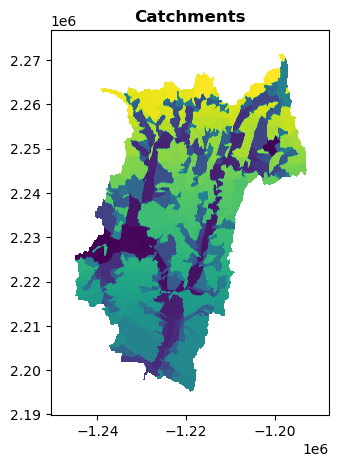

In [14]:
import rasterio as rio

with rasterio.open('./gw_catchments_reaches_filtered_addedAttributes_0.tif') as src:
    raster_data = src.read(1, masked=True)
    transform = src.transform
    
    plt.figure(figsize=(10, 5))
    show(src, title= "Catchments")

In [15]:
input_raster = "gw_catchments_reaches_filtered_addedAttributes_0.tif"
output_masked_raster = "./stage_mask.tif"
 
fim_utils.create_masked_stage_rasters(input_raster, output_masked_raster, res)


HydroID: 27670036, Stage (m): 2.383663785213086
HydroID: 27670037, Stage (m): 2.365816838453226
HydroID: 27670038, Stage (m): 2.284101424736956
HydroID: 27670039, Stage (m): 2.2148316564661132
Masked raster created successfully.


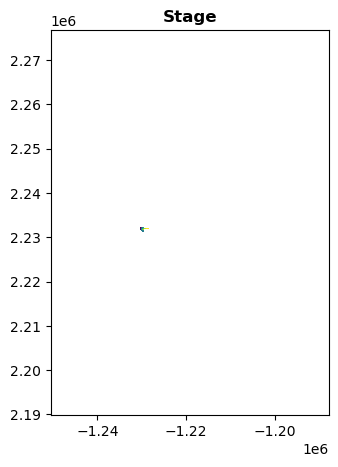

In [16]:
with rasterio.open('./stage_mask.tif') as src:
    raster_data = src.read(1)
    raster_data = raster_data.astype(float)  
    raster_data[raster_data == -99999] = np.nan  # raster_data.min() returns -99999
    transform = src.transform
    
    plt.figure(figsize=(10, 5))
    show(raster_data, transform=transform, title= "Stage")

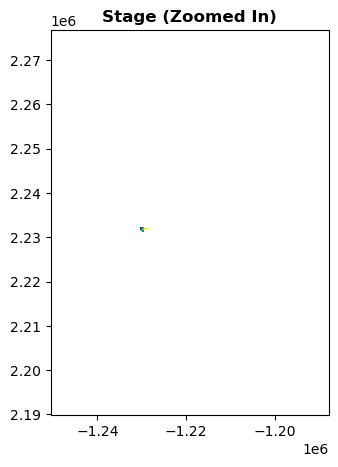

In [17]:
# Open the raster file
with rasterio.open('./stage_mask.tif') as src:
    raster_data = src.read(1)
    raster_data = raster_data.astype(float)
    masked_data = ma.masked_equal(raster_data, -99999.0)  # Mask nodata values
    transform = src.transform

    # Get the extent of the non-NaN values
    non_nan_indices = np.where(~masked_data.mask)
    xmin, ymin = transform * (non_nan_indices[1].min(), non_nan_indices[0].min())
    xmax, ymax = transform * (non_nan_indices[1].max(), non_nan_indices[0].max())

    # Plot the non-NaN areas with adjusted extent
    plt.figure(figsize=(10, 5))
    show(masked_data, transform=transform, extent=(xmin, xmax, ymin, ymax), title="Stage (Zoomed In)")
    plt.show()


In [98]:
hand_raster = "rem_zeroed_masked_0.tif"
stage_raster = "stage_mask.tif"
output_masked_raster = "flood_map.tif"

fim_utils.create_masked_flood_inundation(hand_raster, stage_raster, output_masked_raster)


0.0 991.871826171875
2.214831590652466 2.3836638927459717
-999999.0 100990.875
-1250540.590564116 -1187800.590564116


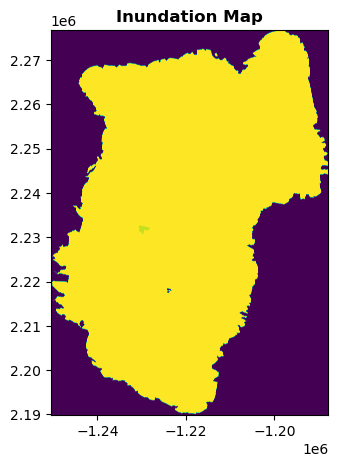

In [99]:
with rasterio.open('./flood_map.tif') as src:
    raster_data = src.read(1)
    transform = src.transform
    
    plt.figure(figsize=(10, 5))
    show(raster_data, transform=transform, title= "Inundation Map")

## The following codes are just tests. They need to be removed later.

In [23]:
# !gdal_polygonize.py flood_map.tif -f "ESRI Shapefile" flood_extent.shp flood


In [24]:
# !gdal_calc.py -A ./flood_map.tif --outfile=./flood_map_1m.tif --calc="A<=1" 

In [25]:
# # Open the raster file
# with rasterio.open('./flood_map.tif') as src:
#     raster_data = src.read(1)
#     raster_data = raster_data.astype(float)
#     masked_data = ma.masked_equal(raster_data, -99999.0)  # Mask nodata values
#     transform = src.transform
#     profile = src.profile  # Get the metadata profile from the source raster

# # Create a new GeoTIFF file and write the masked data
# output_file = './masked_floodmap_1m.tif'
# with rasterio.open(output_file, 'w', **profile) as dst:
#     dst.write(masked_data.filled(-99999.0), 1)  # Fill masked values with -99999.0 and write to the new file


In [101]:
import numpy as np

# Example data with floats
data = np.array([1.0, 2.0, -99999.0, 4.0, 5.0])

# Replace -99999 with NaN
result = np.where(data == -99999.0, np.nan, data)

# When using np.where with np.nan to replace values in a NumPy array. 
# When a NaN value is introduced into an array, it can affect subsequent calculations, 
# such as finding the minimum and maximum values.
# Filter out NaN values. 
result_filtered = result[~np.isnan(result)]

# Check min and max of filtered array
print(result_filtered.min())  # Should print 1.0
print(result_filtered.max())  # Should print 5.0



1.0
5.0


In [4]:
import numpy as np
from osgeo import gdal

def create_masked_raster(input_raster, output_masked_raster, hydroID, stage):
    # Open the input raster file (in our case this is the catchments raster file)
    ds = gdal.Open(input_raster)
    if ds is None:
        print("Could not open input raster file")
        return
    
    # Read raster band as a numpy array
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    
    # Create a mask for the target value
    mask = np.where(arr == hydroID, stage, -99999)  #####  GeoTIFF format does not support NaN directly. So, np.nan and 0 are not different!! 
    
    # Create a new raster with the mask
    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(output_masked_raster, ds.RasterXSize, ds.RasterYSize, 1, gdal.GDT_Byte)
    out_ds.SetProjection(ds.GetProjection())
    out_ds.SetGeoTransform(ds.GetGeoTransform())
    out_band = out_ds.GetRasterBand(1)
    out_band.WriteArray(mask)
    
    # Close the datasets
    ds = None
    out_ds = None
    
    print("Masked raster created successfully.")

# Example usage
input_raster = "gw_catchments_reaches_filtered_addedAttributes_0.tif"
output_masked_raster = "./output_masked.tif"
hydroID = 27670095
stage = 3
create_masked_raster(input_raster, output_masked_raster, hydroID, stage)


Masked raster created successfully.


In [7]:
import rasterio
import numpy as np

# Open the two input raster files
input_raster1 = 'rem_zeroed_masked_0.tif'  
input_raster2 = 'output_masked.tif'  

with rasterio.open(input_raster1) as src1, rasterio.open(input_raster2) as src2:
    hand = src1.read(1, masked=True)
    stage = src2.read(1, masked=True)
    
    # Perform subtraction and handle NaN values
    result = np.where(stage.mask, np.nan, hand - stage)
    threshold = -0.000000000000000000001  # Adjust the threshold as needed based on your data
    result = np.where(result < threshold, 1, 0)

    # Define the output raster metadata based on one of the input rasters
    profile = src1.profile  # Using profile from input_raster1
    profile.update(dtype=rasterio.float32, nodata=np.nan)  # Update data type and nodata value
    
    # Update metadata with actual data range for better visualization
    profile['min'] = float(result.min())
    profile['max'] = float(result.max())

# Write the result to a new raster file
output_raster = 'output_subtraction.tif'  # Modify with your desired output file path
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(result.astype(rasterio.float32), 1)

print(f"Subtraction result saved to {output_raster}")


Subtraction result saved to output_subtraction.tif


2024-03-12 21:28:48,771 - distributed.nanny - WARNING - Restarting worker
2024-03-12 21:28:48,783 - distributed.nanny - WARNING - Restarting worker
2024-03-12 21:28:48,887 - distributed.nanny - WARNING - Restarting worker
2024-03-12 21:28:49,194 - distributed.nanny - WARNING - Restarting worker
2024-03-12 21:28:50,203 - distributed.nanny - WARNING - Restarting worker
2024-03-12 21:28:50,637 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-g83b7lgz', purging


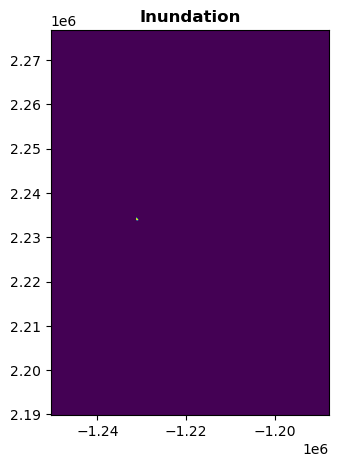

In [80]:
with rasterio.open('./output_subtraction.tif') as dsp:
    data = dsp.read(1)
    transform = dsp.transform   
    plt.figure(figsize=(10, 5))
    show(data, transform=transform, title="Inundation")

Add a new band to a tif file


In [81]:
# Open the HAND GeoTIFF file in read mode
existing_file = 'rem_zeroed_masked_0.tif'
with rasterio.open(existing_file, 'r') as src:
    # Read the existing band data
    existing_band = src.read(1)

    # Get metadata from the existing file
    profile = src.profile

# Add the catchment mask tif 

# Create a new band with stage values 


    
# Create a new band with desired data (e.g., all zeros for demonstration)
new_band_data = np.zeros_like(existing_band)

# Update the profile for the new band
profile.update(count=2, dtype=rasterio.float32)  # Update band count and data type as needed

# Open a new GeoTIFF file in write mode and write the existing and new bands
new_file = 'new_file.tif'
with rasterio.open(new_file, 'w', **profile) as dst:
    # Write the existing band
    dst.write(existing_band, 1)

    # Write the new band
    dst.write(new_band_data, 2)

print(f"New band added and saved to {new_file}")

New band added and saved to new_file.tif


In [ ]:
with rasterio.open('new_file.tif', 'r') as src:
    # Read the existing band data
    existing_band = src.read(1)

Save geotif as netcdf

In [85]:
import xarray as xr
import rasterio
from rasterio.enums import Resampling

# Open the two-band GeoTIFF file
input_tif = 'new_file.tif'  # Update with your file path
with rasterio.open(input_tif) as src:
    # Read bands as numpy arrays
    band1 = src.read(1)
    band2 = src.read(2)

    # Get spatial information from the GeoTIFF
    transform = src.transform
    crs_str = src.crs.to_proj4()

    # Create xarray DataArray for each band
    da_band1 = xr.DataArray(band1, dims=('y', 'x'), attrs={'crs': crs})
    da_band2 = xr.DataArray(band2, dims=('y', 'x'), attrs={'crs': crs})

    # Create xarray DataArray for each band
    da_band1 = xr.DataArray(band1, dims=('y', 'x'), attrs={'crs': crs_str})
    da_band2 = xr.DataArray(band2, dims=('y', 'x'), attrs={'crs': crs_str})

    # Combine bands into a Dataset
    ds = xr.Dataset({'band1': da_band1, 'band2': da_band2})

    # Set spatial information in the Dataset
    ds.attrs['transform'] = transform

    # Save the Dataset as NetCDF file
    output_nc = 'output.nc'  # Output NetCDF file path
    ds.to_netcdf(output_nc)

print(f"NetCDF file saved to {output_nc}")


NetCDF file saved to output.nc


In [86]:
nc = xarray.open_dataset('./output.nc')

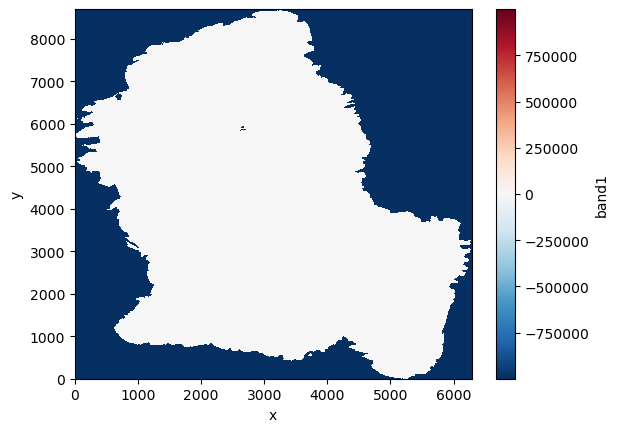

In [89]:
nc.band1.plot()

Define functions

In [2]:
def interpolate_y(df, x_column, y_column, x_value):
    # Sort the DataFrame by the 'x' column to ensure interpolation works correctly
    df_sorted = df.sort_values(by=x_column)
    
    # Check if the x_value is within the range of the DataFrame
    if x_value < df_sorted[x_column].min() or x_value > df_sorted[x_column].max():
        return None  # x_value is out of range, cannot interpolate
    
    # Perform linear interpolation
    f = interpolate.interp1d(df_sorted[x_column], df_sorted[y_column], kind='linear')
    
    # Return the interpolated y value for the given x value
    return f(x_value)


# Function to perform raster calculation 
def raster_calculation(input_raster, output_raster, constant_value):
    with rasterio.open(input_raster) as src:
        # Read raster data
        raster_data = src.read(1)
        # Perform raster calculation
        result = raster_data - constant_value

        # Update metadata
        meta = src.meta
        meta.update(dtype=rasterio.float32)

        # Write the result to a new raster file
        with rasterio.open(output_raster, 'w', **meta) as dst:
            dst.write(result.astype(rasterio.float32), 1)
            
            
# def raster_to_polygon(input_raster, output_polygon):
#     # Run gdal_polygonize.py as a subprocess
#     subprocess.call(["gdal_polygonize.py", input_raster, "-b", "1", "-f", "ESRI Shapefile", output_polygon, output_polygon, "COMID"])
